In [4]:
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import resample
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

In [5]:
csv_path = r"C:\Users\asamy\anaconda3\Projects\Planet diseases\Data\train.csv"
image_dir = r"C:\Users\asamy\anaconda3\Projects\Planet diseases\Data\train_images"
df = pd.read_csv(csv_path)
df

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


In [6]:
available_images = set(os.listdir(image_dir))

df['image_id'] = df['image_id'].apply(lambda x: f"{x}" if x.endswith('.jpg') else f"{x}.jpg")

df['exists'] = df['image_id'].apply(lambda x: x in available_images)

df_cleaned = df[df['exists'] == True]

df_cleaned = df_cleaned.drop(columns=['exists'])

print(f"Total available images: {len(df_cleaned)}")

Total available images: 17938


In [7]:
value_counts = df_cleaned['label'].value_counts()
value_counts

label
3    11027
4     2166
2     1993
1     1831
0      921
Name: count, dtype: int64

In [8]:
df_cleaned['label'] = df_cleaned['label'].astype(str)

def oversample_class(df, class_label, target_size):
    class_df = df[df['label'] == class_label]
    if len(class_df) < target_size:
        oversampled = resample(class_df, replace=True, n_samples=target_size, random_state=42)
        return oversampled
    else:
        return class_df

class_0_oversampled = oversample_class(df_cleaned, '0', 10000)
class_1_oversampled = oversample_class(df_cleaned, '1', 10000)
class_2_oversampled = oversample_class(df_cleaned, '2', 10000)
class_4_oversampled = oversample_class(df_cleaned, '4', 10000)

class_3_df = df_cleaned[df_cleaned['label'] == '3'].sample(n=10000, random_state=42)  # Sample down to 10,000 if needed

balanced_train_df = pd.concat([class_0_oversampled, class_1_oversampled, class_2_oversampled, class_3_df, class_4_oversampled])

balanced_train_df = balanced_train_df.sample(frac=1).reset_index(drop=True)


In [9]:
train_df, val_df = train_test_split(balanced_train_df, test_size=0.2, random_state=42)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create training generator
train_generator = train_datagen.flow_from_dataframe(
    train_df, directory=image_dir, x_col='image_id', y_col='label',
    target_size=(128, 128),color_mode='grayscale', batch_size=64, class_mode='categorical'
)

# Create validation generator
val_generator = val_datagen.flow_from_dataframe(
    val_df, directory=image_dir, x_col='image_id', y_col='label',
    target_size=(128, 128),color_mode='grayscale', batch_size=64, class_mode='categorical'
)

Found 40000 validated image filenames belonging to 5 classes.
Found 10000 validated image filenames belonging to 5 classes.


In [10]:
input_layer = Input(shape=(128, 128, 1))

x = Conv2D(3, (3, 3), padding='same')(input_layer)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
output_layer = Dense(5, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)


In [11]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1)


model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [lr_scheduler]

history = model.fit(train_generator,
                    epochs=25,
                    validation_data=val_generator,
                    callbacks=callbacks)


Epoch 1/25
625/625 [==============================] - 225s 340ms/step - loss: 1.2500 - accuracy: 0.4782 - val_loss: 2.1227 - val_accuracy: 0.2434 - lr: 1.0000e-04
Epoch 2/25
625/625 [==============================] - 206s 329ms/step - loss: 1.0493 - accuracy: 0.5756 - val_loss: 3.3604 - val_accuracy: 0.2007 - lr: 1.0000e-04
Epoch 3/25
625/625 [==============================] - 201s 322ms/step - loss: 0.9250 - accuracy: 0.6328 - val_loss: 2.7562 - val_accuracy: 0.2600 - lr: 1.0000e-04
Epoch 4/25
625/625 [==============================] - ETA: 0s - loss: 0.8147 - accuracy: 0.6844
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
625/625 [==============================] - 206s 329ms/step - loss: 0.8147 - accuracy: 0.6844 - val_loss: 2.3629 - val_accuracy: 0.3300 - lr: 1.0000e-04
Epoch 5/25
625/625 [==============================] - 207s 330ms/step - loss: 0.6893 - accuracy: 0.7370 - val_loss: 1.8518 - val_accuracy: 0.4322 - lr: 5.0000e-05
Epoch 6/25
625/625 [====

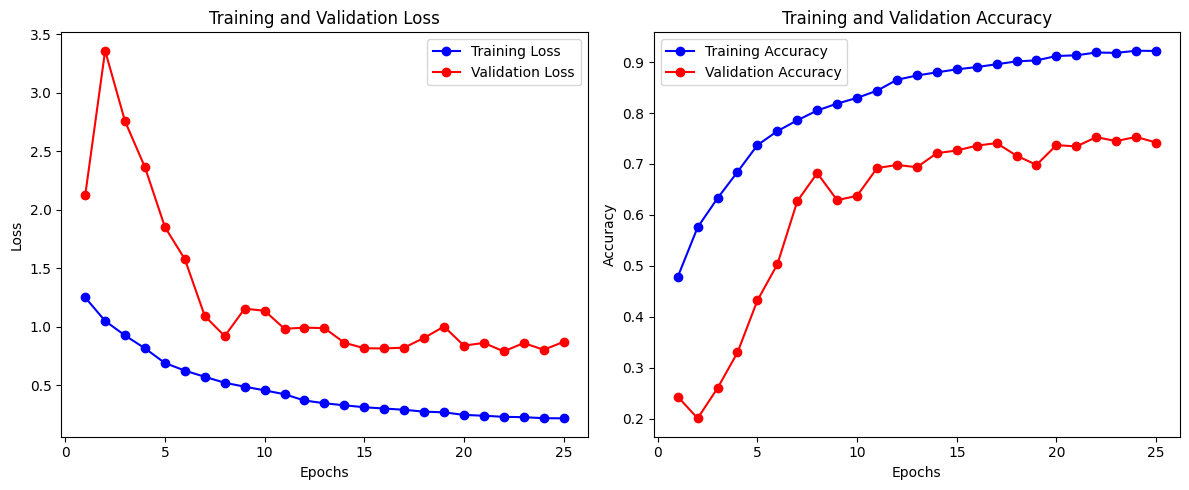

In [12]:
import matplotlib.pyplot as plt

history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']  
val_acc = history_dict['val_accuracy']  

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


2/2 [==============================] - 1s 9ms/step


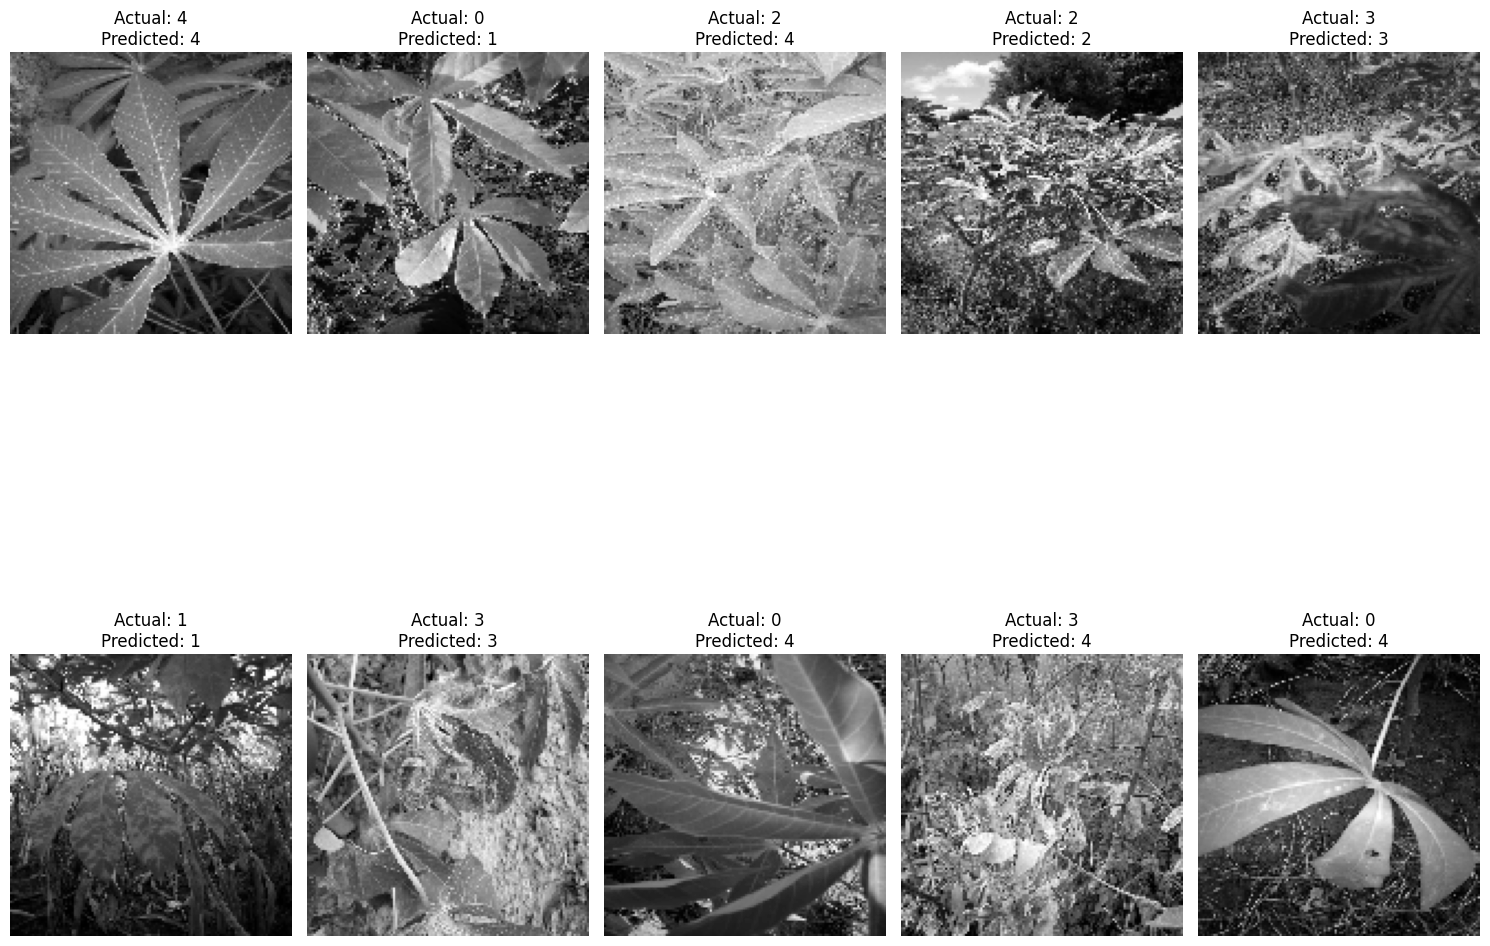

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

num_images = 10

images, labels = next(val_generator)  # Get the next batch from the generator

class_indices = val_generator.class_indices
class_labels = list(class_indices.keys())

predictions = model.predict(images)

predicted_labels = np.argmax(predictions, axis=1)
actual_labels = np.argmax(labels, axis=1)

plt.figure(figsize=(15, 15))

for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].reshape(128, 128), cmap='gray')
    
    actual_label = class_labels[actual_labels[i]]
    predicted_label = class_labels[predicted_labels[i]]
    
    plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [13]:
model.save('mobilenetv2_crop_disease.h5')

In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()
with open('mobilenetv2_crop_disease.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\asamy\AppData\Local\Temp\tmp3paynwy_\assets


INFO:tensorflow:Assets written to: C:\Users\asamy\AppData\Local\Temp\tmp3paynwy_\assets


In [17]:
import numpy as np
import tensorflow as tf
from PIL import Image

# Function to preprocess the image (resize and rescale)
def preprocess_image(image_path):
    # Load the image from the file
    img = Image.open(image_path).convert('L')  # Convert to grayscale (L mode)
    
    # Resize the image to the target size (128x128)
    img = img.resize((128, 128))
    
    # Convert the image to a numpy array
    img_array = np.array(img).astype(np.float32)
    
    # Rescale the image (the model was trained with rescale=1./255)
    img_array = img_array / 255.0
    
    # Add a batch dimension (model expects input shape (1, 128, 128, 1))
    img_array = np.expand_dims(img_array, axis=0)
    img_array = np.expand_dims(img_array, axis=-1)  # To add the channel dimension for grayscale
    
    return img_array

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="mobilenetv2_crop_disease.tflite")
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to make predictions using the TFLite model
def predict_tflite(image_path):
    # Preprocess the image
    img_array = preprocess_image(image_path)
    
    # Set the tensor for the input
    interpreter.set_tensor(input_details[0]['index'], img_array)
    
    # Run inference
    interpreter.invoke()
    
    # Get the output predictions
    output = interpreter.get_tensor(output_details[0]['index'])
    
    # Get the predicted class
    predicted_class = np.argmax(output)
    
    return predicted_class, output

# Test the TFLite model on specific images
test_image_path = r"C:\Users\asamy\anaconda3\Projects\Planet diseases\Data\sorted_images\2\63775422.jpg"
predicted_class, output_probs = predict_tflite(test_image_path)

# Print the predicted class and output probabilities
print(f"Predicted class: {predicted_class}")
print(f"Output probabilities: {output_probs}")


Predicted class: 2
Output probabilities: [[7.5394722e-09 3.9306160e-02 6.5582091e-01 2.5352952e-01 5.1343448e-02]]
